# pyBIS - Getting Started

*Carlos Madariaga*

*Jörg Rädler*

February 2024

## Intro

This tutorial is about accessing and interacting with openBIS from Python scripts via pyBIS. It focuses on the project [BAM Data Store](https://datastore.bam.de/) and is intended to train BAM employees in automating tasks in openBIS via scripts.
pyBIS is a Python module for interacting with openBIS. pyBIS is designed to be most useful in a Jupyter Notebook or IPython environment, especially if you are developing Python scripts for automatisation. Jupyter Notebooks offer some sort of IDE for openBIS, supporting TAB completition and immediate data checks, making the life of a researcher hopefully easier.

#### IMPORTANT: Requirements to follow this workshop:

* You have already completed the onboarding to openBIS (or you have a username and password to access openBIS).
* You have a basic knowledge of the openBIS platform.m.

### Documentation 

#### openBIS

* openBIS: https://www.openbis.ch
* pyBIS: https://pypi.org/project/PyBIS/
* Jupyter: https://jupyter.org/

You need:
* an openBIS server to work with (we use https://schulung.datastore.bam.de in this tutorial),
* an account (username and password) on this server (try log into the ELN first).
* Python3 with Jupyter - if you are running this notebook you probably have it installed already,
* pyBIS package - otherwise you get an `ModuleNotFoundError`when importing the module (install with `pip install pybis` on your command line).

### Warning

**With pyBIS you can do almost everything you can do in the ELN-LIMS User Interface (UI) - but much faster and without manual clicking! It is very easy to automate things, even errors. In the ELN, you would never create 1000 experimental steps by accident with one action, using pyBIS this is possible! Be warned and be careful!**

The following three lines will print the numbers from 0 to 999 and then create **ONE** experimental step:
```
for i in range(1000):
    print(i)
o.new_object(type='EXPERIMENTAL_STEP', collection='/FOO/BAR/BAZ').save()
```

A small change in indentation will instead print the numbers from 0 to 999 while creating **ONE THOUSAND** experimental steps within seconds:
```
for i in range(1000):
    print(i)
    o.new_object(type='EXPERIMENTAL_STEP', collection='/FOO/BAR/BAZ').save()
```


## Initial Setup

### Installing pyBIS and Jupyter
This part from the presentation is skipped. If you can read this you will already have Python and Jupyter up and running

### Connect to an openBIS Instance with user and password

The first step to start using pyBIS, as we just saw before in this tutorial, is to connect to the instance where we want to work. 

This first method needs to introduce user and password directly in the code. In this tutorial we are going to use our BAM user names and passwords, since this will be the method for actually accessing openBIS in practice.

In [ ]:
from pybis import Openbis #import openBIS object to work with the instance

o = Openbis('https://main.datastore.bam.de/', verify_certificates=False) #create openBIS object: equivalent to open the openBIS instance on the browser
o.login('usr', 'psswd', save_token=True)             # usr: your BAM user// psswd: your BAM password. save_token saves the openBIS token to ~/.pybis

The method above works fine. However, **you should never store these credentials in a source code file!** Here we use the `getpass` module to request the password interactively from the user. This works in python scripts as well as in jupyter notebooks.
On successfull login a session token is generated and stored.

In [ ]:
import getpass             # module to prompt for a password
from pybis import Openbis

o = Openbis('https://main.datastore.bam.de/', verify_certificates=False)
o.login('cmadaria', getpass.getpass(), save_token=True)  # get the password (hidden) and save_token saves the openBIS token to ~/.pybis

### Alternative: Personal Access Tokens (PATs)

Openbis introduced **Personal Access Tokens (PAT)** to enable long-lasting sessions. It is extremely useful for automation. The method is the same, but adding the last instruction after the login to save the PAT.

In [ ]:
import getpass
from pybis import Openbis

# to generate PAT you need to login normally
o = Openbis(url='https://main.datastore.bam.de/', verify_certificates=False)
o.login('cmadaria', getpass.getpass(), save_token=True)  # save_token saves the openBIS token to ~/.pybis

pat = o.get_or_create_personal_access_token('test-session') #create the PAT with the given name
pat #show the pat

This will prompt all the information about the PAT, including the *PAT permId*, which will be the code that will be using to login into the openBIS instance without introducing user and password. 

Here we can see an example of how this connection will be made using the already saved PAT.

In [ ]:
from pybis import Openbis

o = Openbis(url='https://main.datastore.bam.de/', token=pat.permId, verify_certificates=False) # here we specify the token to avoid using username and password
o.is_session_active() # check if the openBIS session is active

### Optional: check the pyBIS version

You may print the version of pyBIS and compare with https://pypi.org/project/PyBIS/. If you need to update you may use `pip install --upgrade pybis` on you command line.

In [ ]:
import pybis
print(pybis.__version__) #check pyBIS version, so we can check that it is correctly installed

In [ ]:
o.get_server_information().openbis_version #same with openBIs version on the instance

## Masterdata

#### **In this image we can see the structure of the masterdata in openBIS. As you can see, the data is dividided in "boxes" that contain other boxes. you can imagine this structure as folders, and the last type, the *DataSet*, contains the real files. These are the different entities which we are going to work with:**

**SPACE - PROJECT - COLLECTION - OBJECT - DATASET**

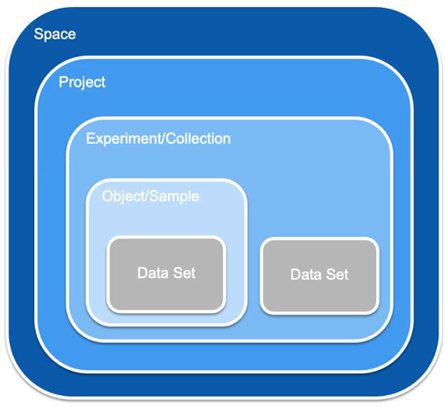

## How to create, edit and access entities via pyBIS

#### **Now we are going to explain the workflow that we will follow on this tutorial. Then, after each topic represented in the following schema, we will have a small task about it. The solution is hidden under the code. Check it if you do not know how to proceed or if you need some hints about the exercise**

**In the tutorial we are going to simulate the creation of a experiment, with different experimental steps and data for each one. At the end, we will work on a real-life example, to practice everything learnt.**

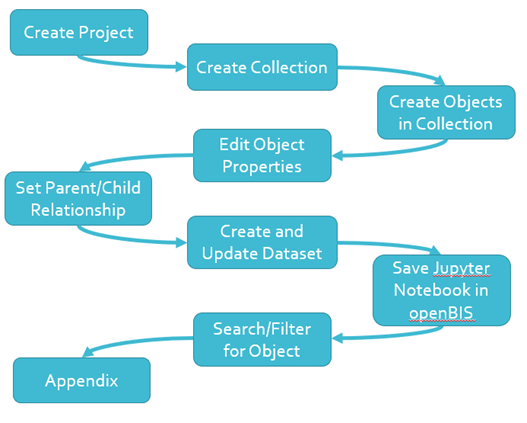

**We will start by creating a *Project* in our *Space*, then a *Collection*, and then we will create *Objects* in that *Collection*. Later, we will learn how to edit the *Properties* for the *Objects*, and also how to set *Parent/Child* relationships to them. Then we will explore the *Datasets*, how to create and delete them, and how to upload and download files. Also, we Will learn how to upload our jupyter notebook to openBIS using a *DataSet*. Finally, we will check the different methods to *Search and Filter* for *Objects* and other entities. Aditionally, we will explore some extra functions, a bit more advance, that will help us in some ocassions using pyBIS, like *Transactions* or *Dataframes*.**


*HINT*: *If you want to know the methods that you can use of an *Object*, you can use the function* **dir()**; *for example: dir(o) will print all the methods and functions available for the Openbis object 'o'.*

### Spaces

The first step into the process will be find our ***Space*** in the system. To do so, we should execute the following function, and check where is our user name.

**It is very important that you select your space here. If not, you will be modifying the space and data of other people and colleagues!!**

##### **TASK 0: Get all the available *Spaces* and save yours in a variable "space"**.

In [ ]:
o.get_spaces()

In [ ]:
my_space = o.get_space("VP.1_CMADARIA")

In [ ]:
my_space

### Projects

Once this is done, we are going to create our first **Project** in our *Space*. To do so, having already our *Space* code, we need to set a variable (like *project* in our case) and call the function 'new_project()' from the openBIS object 'o' that we created at the beginning. 

To execute this function, we will need to specify the code for the new *Project* and our *Space* code.

Then, execute the function 'project.save()', that will upload the *Project* to the openBIS ELN (before doing so, the new *Project* is just saved in the variable 'project'). The function 'save()' is available for every entity in pyBIS, and allows us to create and load all the entity data in openBIS ELN. 

##### **TASK 1: Create a new *Project* in your *Space***.

In [ ]:
my_project = o.new_project(
    code = 'WS_PROJECT',
    space = my_space, # The space variable that we save before in 'TASK 0'
)
my_project.save()

In [ ]:
my_project

### Collections

`Please note that *Collections* were previously called *Experiments* in openBIS. Some of the pyBIS functions still use the old terminology; most of the time the terms *Collection* and *Experiment* can be used interchangeably. An example for an *Collection* type that we are going to work with is DEFAULT_EXPERIMENT.`

Now that we have the *Project* inside our *Space*, the next step will be creating a **Collection**. For doing so, the first thing is to decide the type that we want for our *Collection*. We will need to execute the function 'o.get_collection_types()', and select the desired type.

Then, the creation process is very similar to the one of creating a *Project*. The only difference in this case, is that we need to indicate the *Collection* type and the *Project* where it will be integrated. Finally, as we did before, we save the *Collection* with "collection.save()".

We should see a table summarizing all the data assigned to our newly created *Collection*.

##### **TASK 2: Create new *Collection* inside your *Project* and list all *Collections***.

In [ ]:
o.get_collection_types()

In [ ]:
my_collection = o.new_collection(
    code = 'WS_COLLECTION',
    type = 'COLLECTION',
    project = my_project
)

In [ ]:
my_collection.save()

In [ ]:
my_collection

In [ ]:
o.get_collections()

### Objects

`Please note that *Objects* were previously called *Samples* in openBIS. Some of the pyBIS functions still use the old terminology; most of the time the terms *Object* and *Sample* can be used interchangeably. An example for an *Object* type that we are going to work with is EXPERIMENTAL_STEP.`

As with *Collections*, every *Object* belongs to a specific *Object* type. The type defines the *Properties* of the *Object* and checks them accordingly. So first, we need to check the possible types for our *Object* and select the desired one.
 
Use the o.new_object() method, then provide `type`, `space`, `project`, `collection` attributes. For the type, pick one of the list above. For *Project* and *Collection* you can either use strings or the variables you used above. Assign the new *Object* to the variable *Object*. Finally, save your *Object* as we did before.

Here, we are also indicating the 'code' of the object, which is not mandatory, but will be easier to recognize it.The code should be **unique**; if we do not specify it, the code will be assigned automatically.

#### Creating *Objects* in a *Collection*

Based on the tasks above, follow the same process and try to create a new object, indicating the space, project, collection, the object type (first explore all of the available types as we did before with the collections) and the object code. Finally, save the object and check that your object is at the end of the object list.

##### **EXERCISE 1: Create a new *Object* inside your *Collection* and list all *Objects***.

In [ ]:
# CODE

##### *Solution*

In [ ]:
o.get_object_types()

In [ ]:
my_object = o.new_object(
    type = 'EXPERIMENTAL_STEP', # type for the object. Should be one of the available types on the type list, for example 'EXPERIMENTAL_STEP'
    code = 'WS_OBJECT', #the code for the object. We can leave it empty and it will be generated automatically.
    space = my_space, #the space that we previously got
    project = my_project, # this is the project that we previously created, saved in the variable "new_project"
    collection = my_collection, # this is the collection that we previously created, saved in the variable "new_collection"
)

In [ ]:
my_object.save()

In [ ]:
o.get_objects(space=str(my_space), project="WS_PROJECT")

In [ ]:
sel_object = o.get_object("/VP.1_CMADARIA/WS_PROJECT/WS_COLLECTION/WS_OBJECT") #Here you specify the path you see in the printed list, something like: /CMADARIA/DS_TRAINING/EXP114

In [ ]:
sel_object

#### Editing *Object Properties*

 Every *Object* type defines the variety of *Properties* for that *Object*. You can list the *Properties* of an *Object* like this:

In [ ]:
my_object.props

 To get a dictionary from the *Properties*, use the `object.props()` method:

In [ ]:
my_object.props()

Another way to find out which *Properties* can be set is to write `object.props.` (or `object.p.`) and then hit the `TAB` button

##### **Two ways for assigning values to *Properties***

1.  The most compact way is to assign a dictionary to `object.props`

##### **TASK 3: Assign *Properties* to the *Object* using a dictionary (method 1). Check the *Properties* list of the *Object***

In [ ]:
my_object.props()

In [ ]:
my_object.props = {
    "$name": "experimenting with sample",
    "finished_flag": False,
} #dictionary structure: property name between quotes, colon, property content between quotes, properties separated by commas
# examples for object type = 'EXPERIMENTAL_STEP'. If your object is a different type, select your properties from the list above

***Do not forget to save your Object using*** `object.save()` ***when you have finished modifying its Properties!!! (This will also check if there are missing mandatory Properties)***

In [ ]:
my_object.save()

In [ ]:
my_object.props

2.  Set the value directly accesing to it

This method is recommended as it can handle problematic characters in *Property* names and immediately indicates any error:

##### **TASK 4: Assign *Properties* to the *Object* accesing directly to the property (method 2). Show all the *Properties* to check**

In [ ]:
my_object.props()

In [ ]:
my_object.props['experimental_step.experimental_description'] = 'Experimental step to make experiments with obtained sample'
# accesing a value of the properties dictionary directly: "[]"
# example for object type = 'EXPERIMENTAL_STEP'. If your object is a different type, select your properties from the list above

In [ ]:
my_object.save()

In [ ]:
my_object.props

*Hint*: Use an underscore _ after the *Property* name to to reveal its type. If it is a controlled vocabulary, a list of possible values are presented:

my_object.props['reference_']

#### *Properties*: Summary

As we saw in the examples above, every *Property* has its own **Property type**, e.g. 

- VARCHAR and MULTILINE_VARCHAR (text)
- BOOLEAN (True, False)
- INTEGER
- REAL (floating point numbers)
- TIMESTAMP (date and time)
- XML
- CONTROLLEDVOCABULARY

The *Property* type defines the characteristics of the value a *Property* expects. The value is checked at the moment we assign it to our *Object*. You can add an underscore `_` at the end of each *Property* name to find out about its **type**.

### Setting Parent-Child Relationships between *Objects*

Parent-child relationships are an important concept of openBIS. When we process data in multiple steps from various resources until we get a final result, we want to be able to **trace back** where we started from. Parent-child relationships of ***Objects*** help us to achieve this.

##### **TASK 5: List all of the available *Objects*, create new ones for Parent and Child, and assign them to our current object**

We are going to see an example.

1. First, we will need to list all the available *Objects*:

In [ ]:
o.get_objects()

2. Then, we need to select which *Objects* we want to be the *Parents* and *Children*. Also, we can create new ones, as we are going to do here:

In [ ]:
parent_object = o.new_object(
    type = 'EXPERIMENTAL_STEP',
    space = my_space,
    project = my_project,
    collection = my_collection,
    code = 'PARENT_OBJECT',
)
parent_object.save()

In [ ]:
parent_object.props['$name'] = "PARENT"

In [ ]:
child_object = o.new_object(
    type = 'EXPERIMENTAL_STEP',
    space = my_space,
    project = my_project,
    collection = my_collection,
    code = 'CHILD_OBJECT',
)
child_object.save()

In [ ]:
child_object.props['$name'] = "CHILD"

3. Finally, we need to assign this *Objects* as the *parents* and *children* attributes of our current *Object*. ***Do not forget to save the object after!!***

In [ ]:
my_object.parents = parent_object
my_object.children = child_object
my_object.save()

In [ ]:
o.get_objects(space=str(my_space), attrs=['parents','children'])

#### Different ways of adding and removing *Parents and Children*

There are 3 different ways for adding the relationships.

1. Assigning them (the one that we already saw):

2. Adding them to the ones already existing:

3. Setting them directly (like the first method, but using a list instead):

There are 2 different ways for deleting the relationships.

1. Deleting them from the *Object*:

2. Assigning empty lists to remove all the relationships:

In [ ]:
my_object.set_parents([])
my_object.set_children([])
my_object.save()

In [ ]:
o.get_objects(space=str(my_space), attrs=['parents','children'])

In [ ]:
my_object.set_parents([parent_object])
my_object.set_children([child_object])
my_object.save()

In [ ]:
o.get_objects(space=str(my_space), attrs=['parents','children'])

In [ ]:
my_object.del_parents(parent_object)
my_object.del_children(child_object)
my_object.save()

In [ ]:
o.get_objects(space=str(my_space), attrs=['parents','children'])

In [ ]:
my_object.add_parents(parent_object)
my_object.add_children(child_object)
my_object.save()

In [ ]:
o.get_objects(space=str(my_space), attrs=['parents','children'])

### Datasets

All of the techniques we have seen so far also apply to *Datasets* (with a few subtleties). However, *Datasets* fundamentally different from *Objects* as they now finally contain real files! *Datasets* are the main reason openBIS actually runs a separate DataStore.

As always, the first step will be to check the *Dataset* types and select the desired one. Then, here is the quickest way to register a *Dataset* (*Again, do not forget to "save()" the* *Dataset* *at the end!*):

We can see the list of files of a *Dataset* using this function:

*or with ds.get_files() we can see also their size and crc32 checksum*

The added `original` folder is a relict from early openBIS times...

A *Dataset* does not automatically contain the files - you need to download them:

will download all files of a given *Dataset.

When downloading files from a *DataSet*, pybis will **automatically create a directory** for the resource URL and another directory equally to the permId.

We can define `files` we are interested in, the `destination` folder where we want our files and also omit the automatic `original` and `permId` subfolders.

##### **EXERCISE 2: Register a new *Dataset*, add files to it, list and download them. Delete the *Dataset* afterwards.**

In [ ]:
# CODE

##### *Solution*

In [ ]:
o.get_dataset_types()

In [ ]:
my_dataset = o.new_dataset(
    type = 'RAW_DATA',
    collection = my_collection,
    object = my_object,
    files = ['PyBis_Installation_and_BeginnersTutorial.pdf']
)

In [ ]:
my_dataset.save()

In [ ]:
my_dataset.file_list #or ds.get_files()

In [ ]:
my_dataset.download(destination='data/', create_default_folders=False)

In [ ]:
my_dataset.delete(reason="Job finished")

### Search & Filters for *Objects*

#### Basic search

- `get_object()` expects an identifier of a permId of an *Object*. If the identifier/permId was not found, an Error is raised
- `get_objects()` searches for *Objects*, it will always return a list even no *Object* was found

To search for *Objects* (or *Datasets or Collections* etc.), always use the plural, e.g `get_objects()`, `get_collections()`, `get_datasets()`

##### **TASK 6: Get all the entities created in previous steps and print their information**

In [ ]:
o.get_projects(space=my_space.code)

In [ ]:
project = o.get_project("WS_PROJECT")
project

In [ ]:
o.get_collections(space=my_space.code)

In [ ]:
collection = o.get_collection("/VP.1_CMADARIA/WS_PROJECT/WS_COLLECTION")
collection

In [ ]:
o.get_objects(space=my_space.code)

In [ ]:
object = o.get_object("/VP.1_CMADARIA/WS_PROJECT/WS_OBJECT")
object

In [ ]:
parent = o.get_object("/VP.1_CMADARIA/WS_PROJECT/PARENT_OBJECT")
parent

In [ ]:
child = o.get_object("/VP.1_CMADARIA/WS_PROJECT/CHILD_OBJECT")
child

#### Advance search

The `get_objects()` always returns a list, even in cases where no *Objects* are found.

But it also can retrieve thousands *Objects*, therefore make sure to **always limit your search** by using the `count` parameter:

To get the next 10 *Objects*, use the `start_with` parameter:

The result list has a `totalCount` attribute which tells us the total number of *Objects*.

##### **EXERCISE 3: Print out a *Property* of the *Objects* with type Experimental-Step from index 3 to 8 using a loop**

In [ ]:
# CODE

##### *Solution*

In [ ]:
start_with = 8

In [ ]:
objects = o.get_objects(type="EXPERIMENTAL_STEP", count=6, start_with=start_with)

In [ ]:
for object in objects:
    print(f"experimental step {object.code}")

##### **Try out the different filters for searching *Objects*, *Datasets*, and more! Here you have some more examples.**

Search by *Space, Collection, Parents,* ... --> params: `space`, `collection`, `parents` :

In [ ]:
o.get_objects(space=my_space.code, parents='/VP.1_CMADARIA/WS_PROJECT/PARENT_OBJECT', attrs=['parents'])

Get *Objects* where some *Property* matches a certain string (using the operator `*`):

In [ ]:
o.get_objects(where={'$name':'* XXX'}, props=['$name'])

Search *Objects* using comparative operators on the *Properties* (`>`, `<`, `=`, `>=`, `<=`): 

In [ ]:
o.get_objects(registrationdate='>2023-07-21')

## Appendix

### Transactions & Multiple *Object* management

 A transaction is an all-or-nothing operation. It means, it will either save all *Objects* or none. It is also much faster than saving *Object* by *Object* (up to 1000 *Object*/second).
 
 The first instruction creates the transaction, and the last one is equivalent to the `save()`method that we have seen before, it saves all the changes in openBIS.

In [ ]:
 trans.commit()

We can also use the transactions to update many *Objects* at once:

trans.commit()

Or even delete them, marking the *Objects* and specifying the reason for deleting:

objects = o.get_objects(space='CMADARIA', type='CHEMICAL_ELEMENT', props='*')

trans.commit()

We can also add Parent-Child relationships using transactions. Try it yourself!:

##### **TASK EX: Using transactions, create 10 new *Objects*, and make the *Objects* 1-9 children of *Object* 0**

In [ ]:
objects = o.get_objects(type="EXPERIMENTAL_STEP", count=10, attrs=['parents','children'])

In [ ]:
trans = o.new_transaction()

In [ ]:
for i, object in enumerate(objects):
    if i == 0: continue
    objects[i].parents = [objects[0]]
    trans.add(objects[i])

-----------------------------
(Another option for the loop)

In [ ]:
i = 1
for objects in samples:
    samples[i].parents = [samples[0]]
    trans.add(samples[i])
    i = i+1

----------------------------------

In [ ]:
trans.commit()